In [28]:
!python3 baseline/test.py --max_step=10 --actor=actor.pkl --renderer=renderer_b.pkl --img=image/shapes.png

mkdir: output: File exists
canvas step 0, L2Loss = 0.13174492120742798
canvas step 1, L2Loss = 0.05645575746893883
canvas step 2, L2Loss = 0.033296823501586914
canvas step 3, L2Loss = 0.026551373302936554
canvas step 4, L2Loss = 0.0221798624843359
canvas step 5, L2Loss = 0.01945514976978302
canvas step 6, L2Loss = 0.016423813998699188
canvas step 7, L2Loss = 0.014479990117251873
canvas step 8, L2Loss = 0.014059427194297314
canvas step 9, L2Loss = 0.013589650392532349


In [20]:
!ffmpeg -r 30 -f image2 -i output/generated%d.png -s 512x512 -c:v libx264 -pix_fmt yuv420p video.mp4 -q:v 0 -q:a 0

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox

In [3]:
from IPython.display import display, Image
import moviepy.editor as mpy
display(mpy.ipython_display('video.mp4', height=256, max_duration=100.))
display(Image('output/generated399.png'))

ValueError: The duration of video video.mp4 (66.7) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

In [5]:
import torch

width = 128
canvas = torch.zeros([1, 3, width, width])

x = torch.tensor([[8.3360e-02, 4.2574e-01, 1.1142e-01, 9.8395e-01, 4.6122e-01, 5.2032e-02,
         9.9376e-01, 8.9807e-01, 4.0128e-01, 6.2419e-01, 6.0177e-01, 6.8766e-01,
         7.3925e-01, 5.0657e-01, 5.1957e-01, 9.0552e-01, 9.9895e-01, 9.9976e-01,
         2.9694e-01, 9.9532e-01, 5.9672e-01, 1.0000e+00, 6.4795e-01, 6.2063e-01,
         6.8359e-01, 8.8618e-01, 9.4604e-01, 7.9644e-01, 9.9980e-01, 3.3091e-05,
         8.9011e-02, 7.8174e-01, 9.9111e-01, 9.8194e-01, 2.5966e-01, 5.4206e-01,
         3.4093e-01, 4.2826e-01, 5.1584e-01, 2.0927e-01, 4.6882e-01, 3.9847e-05,
         9.9999e-01, 6.6341e-01, 1.8134e-01, 4.1167e-01, 1.9733e-01, 7.8683e-01,
         6.0166e-01, 1.7535e-01, 2.5377e-01, 3.4096e-01, 7.5044e-01, 8.3815e-01,
         3.6985e-01, 7.7639e-01, 4.2308e-01, 7.6167e-01, 4.5775e-01, 5.4750e-01,
         2.2924e-01, 2.8505e-01, 3.5458e-01, 4.0749e-01, 5.0173e-01]])

In [6]:
from baseline_modelfree.Renderer.bezierpath import BezierPath
import numpy as np

x = x.view(-1, 10 + 3)
paths = np.array([BezierPath(f, width=width).draw() for f in x])
    
stroke = 1 - torch.from_numpy(paths)
stroke = stroke.view(-1, width, width, 1)
color_stroke = stroke * x[:, -3:].view(-1, 1, 1, 3)
stroke = stroke.permute(0, 3, 1, 2)
color_stroke = color_stroke.permute(0, 3, 1, 2)
stroke = stroke.view(-1, 5, 1, width, width)
color_stroke = color_stroke.view(-1, 5, 3, width, width)

for i in range(5):
    canvas = canvas * (1 - stroke[:, i]) + color_stroke[:, i]

In [7]:
from baseline_modelfree.Renderer.bezierpath import BezierPath
import numpy as np

x = x.view(-1, 10 + 3)[0]
path = BezierPath(x, width=width).draw()
    
stroke = 1 - torch.from_numpy(path)
stroke = stroke.view(width, width, 1)
color = torch.tensor([1, 0.5, 0.5])

print(stroke.shape)

print(x[-3:])
color_stroke = stroke * color.view(1, 1, 3)
print(color_stroke.shape)
stroke = stroke.permute(2, 0, 1)
print(stroke.shape)
color_stroke = color_stroke.permute(2, 0, 1)
print(color_stroke.shape)
stroke = stroke.view(-1, 1, width, width)
color_stroke = color_stroke.view(-1, 3, width, width)

canvas = canvas * (1 - stroke) + color_stroke

torch.Size([128, 128, 1])
tensor([0.6018, 0.6877, 0.7393])
torch.Size([128, 128, 3])
torch.Size([1, 128, 128])
torch.Size([3, 128, 128])


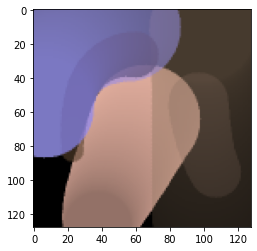

In [8]:
import matplotlib.pyplot as plt
import cv2

output = np.transpose(canvas.numpy(), (0, 2, 3, 1))
output = (output[0] * 255).astype('uint8')

image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(image)

[[1.  1.  1.  0.4]
 [1.  1.  1.  0.4]
 [1.  1.  1.  0.4]
 ...
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]


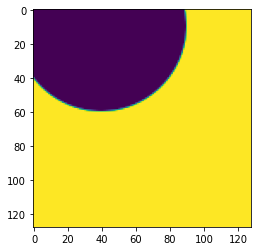

In [9]:
from cairosvg import svg2png

svgstring = "<svg viewBox=\"0 0 {} {}\" xmlns=\"http://www.w3.org/2000/svg\">".format(width * 2, width * 2)
svgstring += "<circle cx=\"{}\" cy=\"{}\" r=\"{}\" fill=\"rgb(255,255,255)\" fill-opacity=\"{}\"/>".format(80, 20, 100, 0.4)
svgstring += "</svg>"

image = svg2png(bytestring=svgstring, write_to=None)
nparr = np.frombuffer(image, np.uint8)
canvas = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)

adjusted = canvas.astype('float32') / 255
print(adjusted[1])
img = 1 - cv2.resize(adjusted[:,:,3], dsize=(width, width))

plt.imshow(img)

[0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.8 1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1. ]


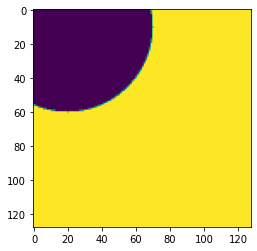

In [16]:
canvas = np.zeros([width * 2, width * 2, 4]).astype('float32')
cv2.circle(canvas, (40, 20), 100, (1, 1, 1, 0.4), -1)

adjusted = canvas[:,:,3]
img = 1 - cv2.resize(adjusted, dsize=(width, width))
print(img[1])

plt.imshow(img)

Training

In [0]:
!mkdir data

In [0]:
cd data

In [0]:
!gdown https://drive.google.com/open?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [0]:
!unzip img_align_celeba.zip

In [0]:
!rm img_align_celeba.zip

In [0]:
cd ..

In [0]:
!python3 baseline/train_renderer.py

In [0]:
!pip install tensorboardX

In [0]:
%%writefile baseline/env.py
import sys
import json
import torch
import numpy as np
import argparse
import torchvision.transforms as transforms
import cv2
from DRL.ddpg import decode
from utils.util import *
from PIL import Image
from torchvision import transforms, utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

aug = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             ])

width = 128
convas_area = width * width

img_train = []
img_test = []
train_num = 0
test_num = 0

class Paint:
    def __init__(self, batch_size, max_step):
        self.batch_size = batch_size
        self.max_step = max_step
        self.action_space = (13)
        self.observation_space = (self.batch_size, width, width, 7)
        self.test = False
        
    def load_data(self):
        # CelebA
        global train_num, test_num
        for i in range(200000):
            img_id = '%06d' % (i + 1)
            try:
                img = cv2.imread('./data/img_align_celeba/' + img_id + '.jpg', cv2.IMREAD_UNCHANGED)
                img = cv2.resize(img, (width, width))
                if i > 2000:                
                    train_num += 1
                    img_train.append(img)
                else:
                    test_num += 1
                    img_test.append(img)
            finally:
                if (i + 1) % 10000 == 0:                    
                    print('loaded {} images'.format(i + 1))
        print('finish loading data, {} training images, {} testing images'.format(str(train_num), str(test_num)))
        
    def pre_data(self, id, test):
        if test:
            img = img_test[id]
        else:
            img = img_train[id]
        if not test:
            img = aug(img)
        img = np.asarray(img)
        return np.transpose(img, (2, 0, 1))
    
    def reset(self, test=False, begin_num=False):
        self.test = test
        self.imgid = [0] * self.batch_size
        self.gt = torch.zeros([self.batch_size, 3, width, width], dtype=torch.uint8).to(device)
        for i in range(self.batch_size):
            if test:
                id = (i + begin_num)  % test_num
            else:
                id = np.random.randint(train_num)
            self.imgid[i] = id
            self.gt[i] = torch.tensor(self.pre_data(id, test))
        self.tot_reward = ((self.gt.float() / 255) ** 2).mean(1).mean(1).mean(1)
        self.stepnum = 0
        self.canvas = torch.zeros([self.batch_size, 3, width, width], dtype=torch.uint8).to(device)
        self.lastdis = self.ini_dis = self.cal_dis()
        return self.observation()
    
    def observation(self):
        # canvas B * 3 * width * width
        # gt B * 3 * width * width
        # T B * 1 * width * width
        ob = []
        T = torch.ones([self.batch_size, 1, width, width], dtype=torch.uint8) * self.stepnum
        return torch.cat((self.canvas, self.gt, T.to(device)), 1) # canvas, img, T

    def cal_trans(self, s, t):
        return (s.transpose(0, 3) * t).transpose(0, 3)
    
    def step(self, action):
        self.canvas = (decode(action, self.canvas.float() / 255) * 255).byte()
        self.stepnum += 1
        ob = self.observation()
        done = (self.stepnum == self.max_step)
        reward = self.cal_reward() # np.array([0.] * self.batch_size)
        return ob.detach(), reward, np.array([done] * self.batch_size), None

    def cal_dis(self):
        return (((self.canvas.float() - self.gt.float()) / 255) ** 2).mean(1).mean(1).mean(1)
    
    def cal_reward(self):
        dis = self.cal_dis()
        reward = (self.lastdis - dis) / (self.ini_dis + 1e-8)
        self.lastdis = dis
        return to_numpy(reward)


In [0]:
!python3 baseline/train.py --max_step=200 --debug --batch_size=96